## Notes
- 100k new credits
- gpu util distributed bug -> try different embedders -> TB runs -> flowmatching
- bug fix takes time due to waiting on full node runs
- leave assymetric time in-output for now
- regularization in embedders
- Space-then-time or time-then-space?
- Swiglu 
- next wednesday prep phase presentation before onboarding DGX B-200
- set up math when model is final

In [9]:
from dataloaders.DiskDatasetDiv import DiskDatasetDiv
from torch.utils.data import Subset   
import torch
from torch.utils.data import DataLoader
import numpy as np
dataset = DiskDatasetDiv(preproc_path='../datasets/prjs1359/preproc_amira-s6', temporal_bundling=3)
#dataset = DiskDatasetDiv(preproc_path='/data/fluidgpt/preproc_pdegym-gauss', temporal_bundling=3)
dataset2 = Subset(dataset, np.arange(0, 64*11))
dataset3 = Subset(dataset, np.random.choice(len(dataset), 64*11, replace=False))
dataset4 = Subset(dataset, np.linspace(0, len(dataset), 64*11, dtype=int, endpoint=False))


In [23]:
import os
import subprocess
def check_mig_with_smi():
    try:
        output = subprocess.check_output(["nvidia-smi", "-L"], text=True)
        return "MIG" in output
    except (subprocess.CalledProcessError, FileNotFoundError):
        return False

if check_mig_with_smi():
    print("Running on a GPU MIG instance")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
else:
    print("Not running on a GPU MIG instance")

Running on a GPU MIG instance


In [10]:
dataloader1 = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=8)
print(len(dataloader1))
for i, data in enumerate(dataloader1):
    print(i, data[0].shape, data[1].shape, end='\r')
    if i == 10:
        break

7793


In [11]:
dataloader1 = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8)
print(len(dataloader1))
for i, data in enumerate(dataloader1):
    print(i, data[0].shape, data[1].shape, end='\r')
    if i == 10:
        break

7793


In [12]:
dataloader2 = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8)
print(len(dataloader2))
for i, data in enumerate(dataloader2):
    print(i, data[0].shape, data[1].shape, end='\r')
    if i == 10:
        break

7793


In [13]:
dataloader3 = DataLoader(dataset2, batch_size=64, shuffle=False, num_workers=8)
print(len(dataloader3))
for i, data in enumerate(dataloader3):
    print(i, data[0].shape, data[1].shape, end='\r')

11


In [14]:
dataloader4 = DataLoader(dataset3, batch_size=64, shuffle=False, num_workers=8)
print(len(dataloader4))
for i, data in enumerate(dataloader4):
    print(i, data[0].shape, data[1].shape, end='\r')

11


In [15]:
dataloader5 = DataLoader(dataset4, batch_size=64, shuffle=False, num_workers=8)
len(dataloader5)
for i, data in enumerate(dataloader5):
    print(i, data[0].shape, data[1].shape, end='\r')

In [16]:
dataloader1 = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=64, persistent_workers=True)
for i, (x, y) in enumerate(dataloader1):
    print(i, x.shape, y.shape, end='\r')
    if i == 100:
        break

/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 9, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [17]:
dataloader1 = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=32, persistent_workers=True)
for i, (x, y) in enumerate(dataloader1):
    print(i, x.shape, y.shape, end='\r')
    if i == 100:
        break

/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 9, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [18]:
dataloader1 = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=16, persistent_workers=True)
for i, (x, y) in enumerate(dataloader1):
    print(i, x.shape, y.shape, end='\r')
    if i == 100:
        break

/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 9, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [19]:
dataloader1 = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8, persistent_workers=True)
for i, (x, y) in enumerate(dataloader1):
    print(i, x.shape, y.shape, end='\r')
    if i == 100:
        break

In [21]:
from modelComp.FluidGPT import FluidGPT
model = FluidGPT()
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model.train()
for i, (x,y) in enumerate(dataloader5):
    #print(i, data[0].shape, data[1].shape, end='\r')
    model.zero_grad()
    x, y = x.cuda(), y.cuda()
    x = model(x)
    loss = torch.nn.functional.mse_loss(x, y)
    loss.backward()
    optimizer.step()
    print(i, x.shape, y.shape, end='\r')
    if i == 10:
        break 
print(y.shape)

/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


DeferredCudaCallError: CUDA call failed lazily at initialization with error: device >= 0 && device < num_gpus INTERNAL ASSERT FAILED at "/pytorch/aten/src/ATen/cuda/CUDAContext.cpp":52, please report a bug to PyTorch. device=1, num_gpus=1

CUDA call was originally invoked at:

  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/asyncio/base_events.py", line 640, in run_forever
    self._run_once()
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/asyncio/base_events.py", line 1992, in _run_once
    handle._run()
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    await self.process_one()
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    await dispatch(*args)
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    await result
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
    await super().execute_request(stream, ident, parent)
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    reply_content = await reply_content
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
    res = shell.run_cell(
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3047, in run_cell
    result = self._run_cell(
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3102, in _run_cell
    result = runner(coro)
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3489, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3549, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_479099/2834083003.py", line 1, in <module>
    from dataloaders.DiskDatasetDiv import DiskDatasetDiv
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1310, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/gpfs/home5/tharmsen/AutoregressiveNeuralOperators/src/dataloaders/__init__.py", line 1, in <module>
    from .AmiraPreProc import AmiraPreProc
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/gpfs/home5/tharmsen/AutoregressiveNeuralOperators/src/dataloaders/AmiraPreProc.py", line 1, in <module>
    import torch
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/torch/__init__.py", line 2064, in <module>
    _C._initExtension(_manager_path())
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/torch/cuda/__init__.py", line 317, in <module>
    _lazy_call(_check_capability)
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/torch/cuda/__init__.py", line 314, in _lazy_call
    _queued_calls.append((callable, traceback.format_stack()))


In [ ]:
for i in range(101):
    # generate noise
    noise = torch.randn(64, 3, 2, 128, 128).cuda()
    out = model(noise)
    print(i, out.shape, end='\r')

DeferredCudaCallError: CUDA call failed lazily at initialization with error: device >= 0 && device < num_gpus INTERNAL ASSERT FAILED at "/pytorch/aten/src/ATen/cuda/CUDAContext.cpp":52, please report a bug to PyTorch. device=1, num_gpus=1

CUDA call was originally invoked at:

  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/asyncio/base_events.py", line 640, in run_forever
    self._run_once()
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/asyncio/base_events.py", line 1992, in _run_once
    handle._run()
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    await self.process_one()
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    await dispatch(*args)
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    await result
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
    await super().execute_request(stream, ident, parent)
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    reply_content = await reply_content
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
    res = shell.run_cell(
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3047, in run_cell
    result = self._run_cell(
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3102, in _run_cell
    result = runner(coro)
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    coro.send(None)
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3489, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3549, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_479099/2834083003.py", line 1, in <module>
    from dataloaders.DiskDatasetDiv import DiskDatasetDiv
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1310, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/gpfs/home5/tharmsen/AutoregressiveNeuralOperators/src/dataloaders/__init__.py", line 1, in <module>
    from .AmiraPreProc import AmiraPreProc
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/gpfs/home5/tharmsen/AutoregressiveNeuralOperators/src/dataloaders/AmiraPreProc.py", line 1, in <module>
    import torch
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/torch/__init__.py", line 2064, in <module>
    _C._initExtension(_manager_path())
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/torch/cuda/__init__.py", line 317, in <module>
    _lazy_call(_check_capability)
  File "/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/torch/cuda/__init__.py", line 314, in _lazy_call
    _queued_calls.append((callable, traceback.format_stack()))


In [11]:
# print amount of cpu cores
print(f'Number of CPU cores: {torch.get_num_threads()}')
# print amount of cpu cores available

Number of CPU cores: 112


In [ ]:
from torch.utils.data import Dataset
import numpy as np
import torch
import h5py
from dataloaders.utils import spatial_resample
class PDEBenchCompPreProc(Dataset):
    def __init__(self, filepaths, preproc_savepath, resample_shape=128, resample_mode='fourier', timesample=5, dataset_name='pdebenchcomp'):
        self.data_list = []
        self.traj_list = []
        self.ts = None
        self.resample_shape = resample_shape
        self.resample_mode = resample_mode
        self.name = dataset_name
        self.vel_scale = None
        self.dt = timesample
        
        batchread = 50

        for filepath in filepaths:
            with h5py.File(filepath, "r") as f:
                keys = list(f.keys())
                #print(f"Keys in {filepath}: {keys}")
                
                if "Vx" in keys and "Vy" in keys:
                    vx = f["Vx"]
                    vy = f["Vy"]
                    num_samples = vx.shape[0]
                    
                    for i in range(0, num_samples, batchread):
                        end = min(i + batchread, num_samples)

                        vx_batch = vx[i:end] 
                        vy_batch = vy[i:end] 

                        batch = np.stack((vx_batch, vy_batch), axis=2) 
                        batch = torch.from_numpy(batch.astype(np.float32)) 

                        B, T, C, H, W = batch.shape

                        batch = spatial_resample(batch, self.resample_shape, self.resample_mode)
                        #print(batch.shape)
                        print(batch.shape)
                        if self.ts is None:
                            self.ts = batch.shape[1]

                        self.data_list.append(batch)
                        self.traj_list.append(batch.shape[0])
        
        self.data = torch.concat(self.data_list, dim=0)
        print(self.data.shape)
        self.traj = int(sum(self.traj_list))
        self.avg = float(self.data.mean())
        self.std = float(self.data.std())
        # save the data in quick readable format in h5py
        with h5py.File(preproc_savepath, 'w') as f:
            f.create_dataset('data', data=self.data.numpy())
            f.create_dataset('avg', data=self.avg)
            f.create_dataset('std', data=self.std)
            f.create_dataset('resample_shape', data=self.resample_shape)
            f.create_dataset('resample_mode', data=self.resample_mode)
            f.create_dataset('timesample', data=self.dt)
            f.create_dataset('name', data=self.name)
            f.create_dataset('traj', data=self.traj)
            f.create_dataset('ts', data=self.ts)
            f.create_dataset('datashape', data=self.data.shape)

PDEBenchCompPreProc(["../datasets/prjs1359/PDEBench-Comp/2D_CFD_Rand_M0.1_Eta0.1_Zeta0.1_periodic_128_Train.hdf5", "../datasets/prjs1359/PDEBench-Comp/2D_CFD_Rand_M1.0_Eta1e-08_Zeta1e-08_periodic_512_Train.hdf5"],
    '../datasets/prjs1359/preproc_pdebench-comp.pt',
    resample_shape=128,
    resample_mode='fourier')

torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50, 21, 2, 128, 128])
torch.Size([50

In [1]:
import h5py
import torch
from dataloaders.DiskDataset import DiskDataset
import glob
import os

file_list = glob.glob('../datasets/prjs1359/preproc_*')
file_list = [os.path.basename(f) for f in file_list]  # optional: just filenames, not full paths
print(file_list)
for file in file_list:
    dataset = DiskDataset('../datasets/prjs1359/' + file, temporal_bundling=3)
    loader = torch.utils.data.DataLoader(dataset, batch_size=32)
    print(file)
    for idx, (x, y) in enumerate(loader):
        print(idx, x.shape, y.shape)
        if idx==5:
            break

['preproc_pdegym-gauss-tiny.pt', 'preproc_pdebench-incomp.pt', 'preproc_pdegym-gauss-quick3.pt', 'preproc_amira-tiny.pt', 'preproc_pdebench-comp.pt', 'preproc_pdegym-sines.pt', 'preproc_pdegym-gauss.pt', 'preproc_amira.pt']
preproc_pdegym-gauss-tiny.pt
0 torch.Size([32, 3, 2, 128, 128]) torch.Size([32, 3, 2, 128, 128])
1 torch.Size([32, 3, 2, 128, 128]) torch.Size([32, 3, 2, 128, 128])
2 torch.Size([32, 3, 2, 128, 128]) torch.Size([32, 3, 2, 128, 128])
3 torch.Size([32, 3, 2, 128, 128]) torch.Size([32, 3, 2, 128, 128])
4 torch.Size([32, 3, 2, 128, 128]) torch.Size([32, 3, 2, 128, 128])
5 torch.Size([32, 3, 2, 128, 128]) torch.Size([32, 3, 2, 128, 128])
preproc_pdebench-incomp.pt
0 torch.Size([32, 3, 2, 128, 128]) torch.Size([32, 3, 2, 128, 128])
1 torch.Size([32, 3, 2, 128, 128]) torch.Size([32, 3, 2, 128, 128])
2 torch.Size([32, 3, 2, 128, 128]) torch.Size([32, 3, 2, 128, 128])
3 torch.Size([32, 3, 2, 128, 128]) torch.Size([32, 3, 2, 128, 128])
4 torch.Size([32, 3, 2, 128, 128]) torch

In [17]:
import torch
import h5py
from torch.utils.data import Dataset
import numpy as np
from pathlib import Path
from dataloaders.utils import spatial_resample
import json

class AmiraReaderFromAM:
    def __init__(self, filepaths, resample_shape=128, resample_mode='fourier', timesample=5):
        self.data_list = []
        self.traj_list = []
        self.ts = None
        self.resample_shape = resample_shape
        self.resample_mode = resample_mode
        self.name = None
        self.vel_scale = None
        self.dt = timesample
        
        for filepath in filepaths:
            #print(filepath)
            data = torch.from_numpy(self.read_amira_binary_mesh(filepath).copy())
            data = data.permute(0,3,1,2)
            data = spatial_resample(data, self.resample_shape, self.resample_mode)
            self.data_list.append(data)
            self.traj_list.append(torch.tensor(1))
            if self.ts is None:
                self.ts = data.shape[0]
        
        self.data = torch.stack(self.data_list, dim=0)
        #print(self.data.shape)
        self.traj = sum(self.traj_list)

    def read_amira_binary_mesh(self, filename):
        with open(filename, 'rb') as f:
            raw_data = f.read()
        # first occurrence of "@1"
        first_marker_idx = raw_data.find(b'@1')
        if first_marker_idx == -1:
            raise ValueError("Could not find binary data section in Amira file.")
        # second occurrence of "@1"
        second_marker_idx = raw_data.find(b'@1', first_marker_idx + 2)
        if second_marker_idx == -1:
            raise ValueError("Could not find second binary data section in Amira file.")
        data_start = second_marker_idx + 4  # Skip '@1\n'
        binary_data = raw_data[data_start:]
        lattice_shape = (1001, 512, 512, 2)
        float_data = np.frombuffer(binary_data, dtype=np.float32)
        float_data = float_data.reshape(lattice_shape)
        return float_data
        
    def get_single_traj(self, idx):
        full = self.data[idx][::self.dt]
        return full
    
    def normalize_velocity(self, vel_scale):
        self.data = self.data / vel_scale
        self.vel_scale = vel_scale

    def absmax_vel(self):
        return self.data.abs().max()

class AmiraDatasetFromAM(Dataset):
    def __init__(self, reader: AmiraReaderFromAM, temporal_bundling = 1, forward_steps = 1):
        self.reader = reader
        self.traj = reader.traj
        self.dt = reader.dt
        self.ts = reader.ts
        self.tb = temporal_bundling
        self.fs = forward_steps
        self.lenpertraj = self.reader.ts - (1 + self.fs) * self.reader.dt * self.tb + self.reader.dt
        self.idx_window = self.reader.dt * self.tb
        
    def __len__(self):
        return self.reader.traj * self.lenpertraj

    def __getitem__(self, idx):
        traj_idx = idx // self.lenpertraj
        ts_idx = idx % self.lenpertraj
        
        #print(idx, traj_idx, ts_idx, self.lenpertraj, self.reader.traj, self.reader.ts, self.reader.dt, self.tb, self.fs)
        front = self.reader.data[traj_idx][ts_idx : ts_idx + self.idx_window : self.reader.dt]
        label = self.reader.data[traj_idx][ts_idx + self.fs * self.idx_window : ts_idx + (self.fs + 1) * self.idx_window : self.reader.dt]
        return front, label
    
class PDEBenchIncompReader(Dataset):
    def __init__(self, filepaths, resample_shape=128, resample_mode='fourier', timesample=10):
        self.data_list = []
        self.traj_list = []
        self.ts = None
        self.resample_shape = resample_shape
        self.resample_mode = resample_mode
        self.name = None
        self.vel_scale = None
        self.dt = timesample
        
        for filepath in filepaths:
            with h5py.File(filepath, "r") as f:
                keys = list(f.keys())
                #print(f"Keys in {filepath}: {keys}")
                
                if "velocity" in keys:
                    data = torch.from_numpy(f['velocity'][:].astype(np.float32))
                    #print(data.shape)
                    data = data.permute(0, 1, 4, 2, 3)  
                    
                    data = spatial_resample(data, self.resample_shape, self.resample_mode)
                    if self.ts is None:
                        self.ts = data.shape[1]
                    elif self.ts != data.shape[1]:
                        raise ValueError("Mismatch in timestep dimensions across files.")
                    
                    self.data_list.append(data)
                    self.traj_list.append(data.shape[0])
        
        self.data = torch.cat(self.data_list, dim=0)
        self.traj = sum(self.traj_list)
    
    def get_single_traj(self, idx):
        full = self.data[idx][::self.dt]
        #full = spatial_resample(full, self.resample_shape, self.resample_mode)
        return full
    
    def normalize_velocity(self, vel_scale):
        self.data = self.data / vel_scale
        self.vel_scale = vel_scale

    def absmax_vel(self):
        return self.data.abs().max()

class PDEBenchIncompDataset(Dataset):
    def __init__(self, reader: PDEBenchIncompReader, temporal_bundling = 1, forward_steps = 1):
        self.reader = reader
        self.traj = reader.traj
        self.dt = reader.dt
        self.ts = reader.ts
        self.tb = temporal_bundling
        self.fs = forward_steps
        self.lenpertraj = self.reader.ts - (1 + self.fs) * self.reader.dt * self.tb + self.reader.dt
        self.idx_window = self.reader.dt * self.tb

    def __len__(self):
        return self.reader.traj * (self.reader.ts - self.reader.dt)

    def __len__(self):
        return self.reader.traj * self.lenpertraj

    def __getitem__(self, idx):
        traj_idx = idx // self.lenpertraj
        ts_idx = idx % self.lenpertraj
        
        front = self.reader.data[traj_idx][ts_idx : ts_idx + self.idx_window : self.reader.dt]
        label = self.reader.data[traj_idx][ts_idx + self.fs * self.idx_window : ts_idx + (self.fs + 1) * self.idx_window : self.reader.dt]
        return front, label


In [3]:
readerAmira = AmiraReaderFromAM(['../datasets/prjs1359/AmiraSet/0000.am', '../datasets/prjs1359/AmiraSet/4400.am'], resample_shape=32, resample_mode='fourier')
#readerIncomp = PDEBenchIncompReader(['../datasets/prjs1359/PDEBench-Incomp/ns_incom_inhom_2d_512-100.h5'], resample_shape=32, resample_mode='fourier')


In [6]:
# class load in data from certain folder and save in data format, 
# also save variables in json file
readerAmira.data.std()

tensor(0.1655)

In [47]:
class AmiraReaderFromAM_preprocess(Dataset):
    def __init__(self, filepaths, preproc_savepath, resample_shape=128, resample_mode='fourier', timesample=5):
        self.data_list = []
        self.traj_list = []
        self.ts = None
        self.resample_shape = resample_shape
        self.resample_mode = resample_mode
        self.name = 'amira'
        self.vel_scale = None
        self.dt = timesample
        
        for filepath in filepaths:
            #print(filepath)
            data = torch.from_numpy(self.read_amira_binary_mesh(filepath).copy())
            data = data.permute(0,3,1,2)
            data = spatial_resample(data, self.resample_shape, self.resample_mode)
            self.data_list.append(data)
            self.traj_list.append(torch.tensor(1))
            if self.ts is None:
                self.ts = data.shape[0]
        
        self.data = torch.stack(self.data_list, dim=0)
        #print(self.data.shape)
        self.traj = int(sum(self.traj_list))
        self.avg = float(self.data.mean())
        self.std = float(self.data.std())
        # save the data in quick readable format in h5py
        with h5py.File(preproc_savepath, 'w') as f:
            f.create_dataset('data', data=self.data.numpy())
            f.create_dataset('avg', data=self.avg)
            f.create_dataset('std', data=self.std)
            f.create_dataset('resample_shape', data=self.resample_shape)
            f.create_dataset('resample_mode', data=self.resample_mode)
            f.create_dataset('timesample', data=self.dt)
            f.create_dataset('name', data=self.name)
            f.create_dataset('traj', data=self.traj)
            f.create_dataset('ts', data=self.ts)
            f.create_dataset('datashape', data=self.data.shape)

    def read_amira_binary_mesh(self, filename):
        with open(filename, 'rb') as f:
            raw_data = f.read()
        # first occurrence of "@1"
        first_marker_idx = raw_data.find(b'@1')
        if first_marker_idx == -1:
            raise ValueError("Could not find binary data section in Amira file.")
        # second occurrence of "@1"
        second_marker_idx = raw_data.find(b'@1', first_marker_idx + 2)
        if second_marker_idx == -1:
            raise ValueError("Could not find second binary data section in Amira file.")
        data_start = second_marker_idx + 4  # Skip '@1\n'
        binary_data = raw_data[data_start:]
        lattice_shape = (1001, 512, 512, 2)
        float_data = np.frombuffer(binary_data, dtype=np.float32)
        float_data = float_data.reshape(lattice_shape)
        return float_data
    
    

In [49]:
preproc_savepath = '../datasets/prjs1359/AmiraSet/0000_4400_preproc.h5'
preprocAmira = AmiraReaderFromAM_preprocess(['../datasets/prjs1359/AmiraSet/0000.am', '../datasets/prjs1359/AmiraSet/4400.am'], preproc_savepath, resample_shape=32, resample_mode='fourier')

In [43]:
class AmiraDatasetFromAM(Dataset):
    def __init__(self, preproc_path, temporal_bundling = 1, forward_steps = 1):
        self.filepath = preproc_path
        with h5py.File(self.filepath, 'r') as f:
            self.avg = float(f['avg'][()])
            self.std = float(f['std'][()])
            self.resample_shape = int(f['resample_shape'][()])
            self.resample_mode = str(f['resample_mode'][()])
            self.dt = int(f['timesample'][()])
            self.name = str(f['name'][()])
            self.traj = int(f['traj'][()])
            self.ts = int(f['ts'][()])
            self.datashape = tuple(f['datashape'][()])
        self.tb = temporal_bundling
        self.fs = forward_steps
        self.lenpertraj = self.ts - (1 + self.fs) * self.dt * self.tb + self.dt
        self.idx_window = self.dt * self.tb
        
    def __len__(self):
        return self.traj * self.lenpertraj

    def __getitem__(self, idx):
        traj_idx = idx // self.lenpertraj
        ts_idx = idx % self.lenpertraj
        
        with h5py.File(self.filepath, 'r') as f:
            
            front = f['data'][traj_idx][ts_idx : ts_idx + self.idx_window : self.dt]
            label = f['data'][traj_idx][ts_idx + self.fs * self.idx_window : ts_idx + (self.fs + 1) * self.idx_window : self.dt]

        return torch.tensor(front), torch.tensor(label)

In [50]:
dataset = AmiraDatasetFromAM(preproc_savepath, temporal_bundling=1, forward_steps=1)
print(dataset.datashape)
loader = torch.utils.data.DataLoader(dataset, batch_size=200, shuffle=True)
for i, (front, label) in enumerate(loader):
    print(i, front.shape, label.shape)
    if i == 10:
        break

(2, 1001, 2, 32, 32)
0 torch.Size([200, 1, 2, 32, 32]) torch.Size([200, 1, 2, 32, 32])
1 torch.Size([200, 1, 2, 32, 32]) torch.Size([200, 1, 2, 32, 32])
2 torch.Size([200, 1, 2, 32, 32]) torch.Size([200, 1, 2, 32, 32])
3 torch.Size([200, 1, 2, 32, 32]) torch.Size([200, 1, 2, 32, 32])
4 torch.Size([200, 1, 2, 32, 32]) torch.Size([200, 1, 2, 32, 32])
5 torch.Size([200, 1, 2, 32, 32]) torch.Size([200, 1, 2, 32, 32])
6 torch.Size([200, 1, 2, 32, 32]) torch.Size([200, 1, 2, 32, 32])
7 torch.Size([200, 1, 2, 32, 32]) torch.Size([200, 1, 2, 32, 32])
8 torch.Size([200, 1, 2, 32, 32]) torch.Size([200, 1, 2, 32, 32])
9 torch.Size([192, 1, 2, 32, 32]) torch.Size([192, 1, 2, 32, 32])


In [2]:
from modelComp.FluidGPT import FluidGPT
from modelComp.utils import SwiGLU
model = FluidGPT().to(device='cuda')
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in the model: {count_parameters(model):,}")
model2 = FluidGPT(act=SwiGLU).to(device='cuda')
print(f"Number of parameters in the model with SwiGLU: {count_parameters(model2):,}")

Number of parameters in the model: 27,970,376
Number of parameters in the model with SwiGLU: 36,150,952


In [2]:
# following is a gpu mig bug fix
import os
import subprocess
if "MIG" in subprocess.check_output(["nvidia-smi", "-L"], text=True):
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
else:
    print('no mig detected ', os.environ["CUDA_VISIBLE_DEVICES"])

no mig detected  0,1


In [2]:
import matplotlib.pyplot as plt

In [3]:
import torch
from torch.utils.data import Dataset
import h5py
from pathlib import Path
from dataloaders.utils import spatial_resample
import numpy as np

class AmiraReaderFromAM:
    def __init__(self, filepaths, resample_shape=128, resample_mode='fourier', timesample=5):
        self.data_list = []
        self.traj_list = []
        self.ts = None
        self.resample_shape = resample_shape
        self.resample_mode = resample_mode
        self.name = None
        self.vel_scale = None
        self.dt = timesample
        
        for filepath in filepaths:
            #print(filepath)
            data = torch.from_numpy(self.read_amira_binary_mesh(filepath).copy())
            data = data.permute(0,3,1,2)
            data = spatial_resample(data, self.resample_shape, self.resample_mode)
            self.data_list.append(data)
            self.traj_list.append(torch.tensor(1))
            if self.ts is None:
                self.ts = data.shape[0]
        
        self.data = torch.stack(self.data_list, dim=0)
        #print(self.data.shape)
        self.traj = sum(self.traj_list)

    def read_amira_binary_mesh(self, filename):
        with open(filename, 'rb') as f:
            raw_data = f.read()
        # first occurrence of "@1"
        first_marker_idx = raw_data.find(b'@1')
        if first_marker_idx == -1:
            raise ValueError("Could not find binary data section in Amira file.")
        # second occurrence of "@1"
        second_marker_idx = raw_data.find(b'@1', first_marker_idx + 2)
        if second_marker_idx == -1:
            raise ValueError("Could not find second binary data section in Amira file.")
        data_start = second_marker_idx + 4  # Skip '@1\n'
        binary_data = raw_data[data_start:]
        lattice_shape = (1001, 512, 512, 2)
        float_data = np.frombuffer(binary_data, dtype=np.float32)
        float_data = float_data.reshape(lattice_shape)
        return float_data
        
    def get_single_traj(self, idx):
        full = self.data[idx][::self.dt]
        return full
    
    def normalize_velocity(self, vel_scale):
        self.data = self.data / vel_scale
        self.vel_scale = vel_scale

    def absmax_vel(self):
        return self.data.abs().max()

class AmiraDatasetFromAM(Dataset):
    def __init__(self, reader: AmiraReaderFromAM, temporal_bundling = 1, forward_steps = 1):
        self.reader = reader
        self.traj = reader.traj
        self.dt = reader.dt
        self.ts = reader.ts
        self.tb = temporal_bundling
        self.fs = forward_steps
        self.lenpertraj = self.reader.ts - (1 + self.fs) * self.reader.dt * self.tb + self.reader.dt
        self.idx_window = self.reader.dt * self.tb
        
    def __len__(self):
        return self.reader.traj * self.lenpertraj

    def __getitem__(self, idx):
        traj_idx = idx // self.lenpertraj
        ts_idx = idx % self.lenpertraj
        #print(idx, traj_idx, ts_idx, self.lenpertraj, self.reader.traj, self.reader.ts, self.reader.dt, self.tb, self.fs)
        front = self.reader.data[traj_idx][ts_idx : ts_idx + self.idx_window : self.reader.dt]
        label = self.reader.data[traj_idx][ts_idx + self.fs * self.idx_window : ts_idx + (self.fs + 1) * self.idx_window : self.reader.dt]
        return front, label


In [4]:
reader = AmiraReaderFromAM(['../datasets/prjs1359/AmiraSet/0000.am', '../datasets/prjs1359/AmiraSet/4400.am'], resample_shape=256, resample_mode='fourier')

In [5]:
import matplotlib.pyplot as plt
tb = 3
plotting = False
dataset = AmiraDatasetFromAM(reader, temporal_bundling=tb, forward_steps=1)
dataset2 = AmiraDatasetFromAM(reader, temporal_bundling=tb, forward_steps=4)

class ZeroShotSampler(torch.utils.data.Sampler):
    def __init__(self, dataset, train_ratio=0.8, split="train", seed=227, forward_steps=1):
        torch.manual_seed(seed) 
        num_train = int(dataset.traj * train_ratio)
        shuffled_trajs = torch.randperm(dataset.traj).tolist() 
        train_trajs = shuffled_trajs[:num_train]
        self.val_trajs = shuffled_trajs[num_train:]
        train_indices = [t * dataset.lenpertraj + ts for t in train_trajs for ts in range(0, dataset.lenpertraj, forward_steps)]
        val_indices = [t * dataset.lenpertraj + ts for t in self.val_trajs for ts in range(0, dataset.lenpertraj, forward_steps)]
        self.indices = train_indices if split == "train" else val_indices
    def __iter__(self):
        return iter(self.indices)
    def __len__(self):
        return len(self.indices)
    def random_val_traj(self):
        return self.val_trajs[torch.randint(0, len(self.val_trajs), (1,)).item()]
sampler0 = ZeroShotSampler(dataset, train_ratio=0.8, split="val", seed=227, forward_steps=1)
sampler1 = ZeroShotSampler(dataset2, train_ratio=0.8, split="val", seed=227, forward_steps=4)
loader0 = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, sampler0.indices), batch_size=64, shuffle=False)
loader1 = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset2, sampler1.indices), batch_size=64, shuffle=False)
print(sampler0.val_trajs)
print("Dataset length:", dataset.lenpertraj)
'''
for idx, (front, label) in enumerate(loader1):
    print(f"Batch {idx}:", end=" ")
    print("Front shape:", front.shape, end=" ")
    print("Label shape:", label.shape)
    if plotting:
        fig, ax = plt.subplots(2, tb, figsize=(16, 4))
        for i in range(tb):
            ax[0,i].imshow(front[0, i, 1, :, :].cpu().numpy())
            ax[1,i].imshow(label[0, i, 1, :, :].cpu().numpy())
            ax[0,i].set_title(f"Front {i}")
            ax[0,i].axis('off')
            ax[1,i].set_title(f"Label {i}")
            ax[1,i].axis('off')
        plt.tight_layout()
        plt.show()

    #if idx == 15:
    #    break
'''
print(sampler0.indices)
print(sampler1.indices)


[1]
Dataset length: 976
[976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 114

In [ ]:
from modelComp.FluidGPT import FluidGPT
model = FluidGPT(data_dim=[64, 3, 2, 256, 256]).to(device='cuda')
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in the model: {count_parameters(model):,}")

/home/tharmsen/.conda/envs/grad312/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
dataset = AmiraDatasetFromAM(reader, temporal_bundling=3, forward_steps=1)
loadertest = torch.utils.data.DataLoader(dataset, 
                                         batch_size=16, 
                                         shuffle=False,
                                         num_workers=4, 
                                         pin_memory=True)



In [9]:
for idx, (front, label) in enumerate(loadertest):
    front = front.to(device='cuda')
    label = label.to(device='cuda')
    test = front + label
    print(idx, front.shape, label.shape, end="\r")

In [10]:
for idx, (front, label) in enumerate(loadertest):
    front = front.to(device='cuda')
    label = label.to(device='cuda')
    test = front + label
    print(idx, front.shape, label.shape, model(front).shape, end="\r")
    #front + label

In [7]:
def compute_energy_enstrophy_spectra_dirichlet(u, v, Lx=1.0, Ly=1.0):

    nx, ny = u.shape
    dx = Lx / nx
    dy = Ly / ny
    
    # Apply 2D Hanning window to reduce spectral leakage
    window_x = np.hanning(nx)
    window_y = np.hanning(ny)
    window = np.outer(window_x, window_y)
    u_win = u * window
    v_win = v * window

    # Compute wavenumbers
    kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2
    K = np.sqrt(K2)

    # Fourier transforms
    u_hat = np.fft.fft2(u_win)
    v_hat = np.fft.fft2(v_win)

    # Energy spectral density: 0.5 (|û|² + |v̂|²)
    E_k = 0.5 * (np.abs(u_hat)**2 + np.abs(v_hat)**2)

    # Vorticity in Fourier space: ω̂ = i(kx * v̂ - ky * û)
    w_hat = 1j * KX * v_hat - 1j * KY * u_hat
    Z_k = 0.5 * np.abs(w_hat)**2

    # Flatten and bin in radial shells
    K_flat = K.flatten()
    E_flat = E_k.flatten()
    Z_flat = Z_k.flatten()

    k_max = np.max(K_flat)
    n_bins = nx // 2
    k_bins = np.linspace(0, k_max, n_bins + 1)
    k_bins_center = 0.5 * (k_bins[:-1] + k_bins[1:])
    
    # Initialize spectra and count arrays
    E_spectrum = np.zeros(n_bins)
    Z_spectrum = np.zeros(n_bins)
    counts = np.zeros(n_bins)
    
    # Find the bin index for each wavenumber
    bin_idx = np.digitize(K_flat, k_bins) - 1
    for i in range(K_flat.size):
        b = bin_idx[i]
        if 0 <= b < n_bins:
            E_spectrum[b] += E_flat[i]
            Z_spectrum[b] += Z_flat[i]
            counts[b] += 1

    # Normalize by the number of points in each bin
    counts[counts == 0] = 1  # Avoid division by zero
    E_spectrum /= counts
    Z_spectrum /= counts

    return k_bins_center, E_spectrum, Z_spectrum

# Example usage:
data = dataset.reader.data[1,0]
data1 = dataset.reader.data[1,500]
data2 = dataset.reader.data[1,1000]

k, E, Z = compute_energy_enstrophy_spectra_dirichlet(data[0], data[1], Lx=1.0, Ly=1.0)
k2, E2, Z2 = compute_energy_enstrophy_spectra_dirichlet(data1[0], data1[1], Lx=1.0, Ly=1.0)
k3, E3, Z3 = compute_energy_enstrophy_spectra_dirichlet(data2[0], data2[1], Lx=1.0, Ly=1.0)

print(k.shape, E.shape, Z.shape)

/tmp/ipykernel_3591643/3514936070.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  u_win = u * window
/tmp/ipykernel_3591643/3514936070.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  v_win = v * window


(256,) (256,) (256,)


In [ ]:
import numpy as np

import torch

def compute_energy_enstrophy_spectra_periodic_torch(u, v, Lx=1.0, Ly=1.0):
    """
    Compute isotropic energy and enstrophy spectra from 2D velocity fields u, v on GPU.

    Parameters
    ----------
    u, v : torch.Tensor
        2D velocity field components of shape (nx, ny). Must be on the same device.
    Lx, Ly : float
        Physical domain lengths.

    Returns
    -------
    k_bins_center : torch.Tensor
        Wavenumber bin centers.
    E_spectrum : torch.Tensor
        Energy spectrum E(k).
    Z_spectrum : torch.Tensor
        Enstrophy spectrum Z(k).
    """

    device = u.device
    nx, ny = u.shape
    dx = Lx / nx
    dy = Ly / ny

    # Wavenumbers
    kx = torch.fft.fftfreq(nx, d=dx, device=device) * 2 * torch.pi
    ky = torch.fft.fftfreq(ny, d=dy, device=device) * 2 * torch.pi
    KX, KY = torch.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2
    K = torch.sqrt(K2)

    # FFTs
    u_hat = torch.fft.fft2(u, device=device)
    v_hat = torch.fft.fft2(v, device=device)

    # Energy density
    E_k = 0.5 * (torch.abs(u_hat)**2 + torch.abs(v_hat)**2)

    # Vorticity and enstrophy density
    w_hat = 1j * KX * v_hat - 1j * KY * u_hat
    Z_k = 0.5 * torch.abs(w_hat)**2

    # Flatten and bin by K magnitude
    K_flat = K.flatten()
    E_flat = E_k.flatten()
    Z_flat = Z_k.flatten()

    k_max = K_flat.max()
    n_bins = nx // 2
    k_bins = torch.linspace(0, k_max, n_bins + 1, device=device)
    k_bins_center = 0.5 * (k_bins[:-1] + k_bins[1:])

    # Initialize spectra
    E_spectrum = torch.zeros(n_bins, device=device)
    Z_spectrum = torch.zeros(n_bins, device=device)
    counts = torch.zeros(n_bins, device=device)

    # Digitize manually
    bin_idx = torch.bucketize(K_flat, k_bins) - 1
    valid = (bin_idx >= 0) & (bin_idx < n_bins)
    bin_idx = bin_idx[valid]
    E_flat = E_flat[valid]
    Z_flat = Z_flat[valid]

    for i in range(n_bins):
        mask = bin_idx == i
        E_spectrum[i] = E_flat[mask].sum()
        Z_spectrum[i] = Z_flat[mask].sum()
        counts[i] = mask.sum()

    counts[counts == 0] = 1
    E_spectrum /= counts
    Z_spectrum /= counts

    return k_bins_center, E_spectrum, Z_spectrum


# Example usage:
data = dataset.reader.data[1,0]
data1 = dataset.reader.data[1,500]
data2 = dataset.reader.data[1,1000]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
k4, E4, Z4 = compute_energy_enstrophy_spectra_periodic(data[0].to(device), data[1].to(device), Lx=1.0, Ly=1.0)
k5, E5, Z5 = compute_energy_enstrophy_spectra_periodic(data1[0], data1[1], Lx=1.0, Ly=1.0)
k6, E6, Z6 = compute_energy_enstrophy_spectra_periodic(data2[0], data2[1], Lx=1.0, Ly=1.0)


print(k.shape, E.shape, Z.shape)



ValueError: Device not understood. Only "cpu" is allowed, but received: cuda:0

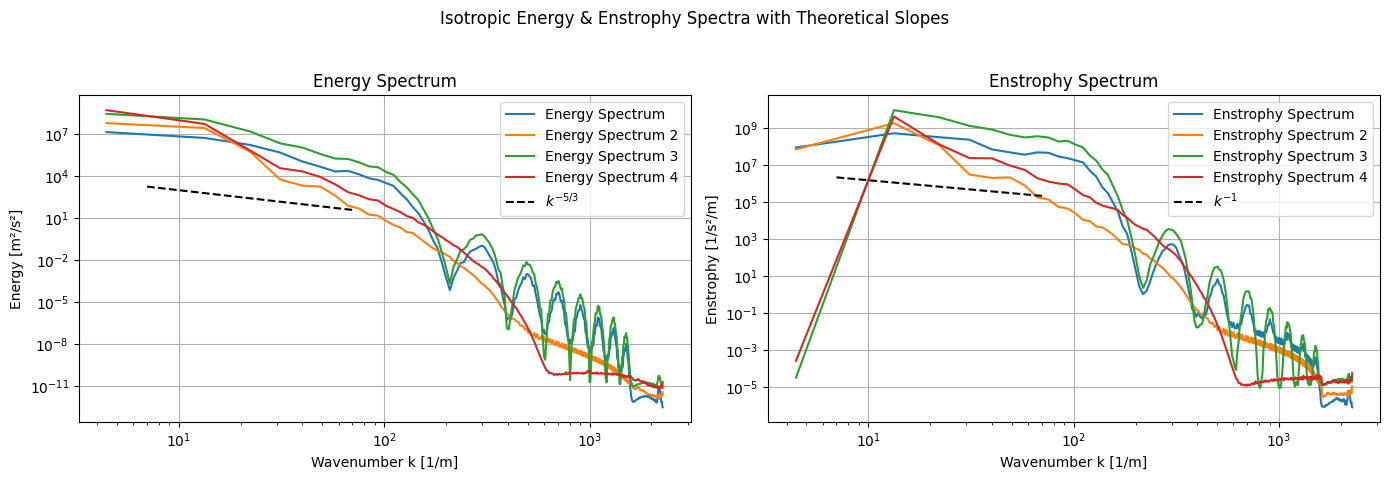

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Choose a range to anchor the reference lines
ref_k = np.array([7,70])

# Reference lines (manually scaled to fit visually)
ref_E_53 = (ref_k / ref_k[0])**(-5/3) * E3[5]
ref_E_3 = (ref_k / ref_k[0])**(-3) * E3[5]
ref_Z_1 = (ref_k / ref_k[0])**(-1) * Z3[5]

# --- Energy Spectrum Plot ---
axs[0].loglog(k, E, label='Energy Spectrum')
axs[0].loglog(k3, E3, label='Energy Spectrum 2')
axs[0].loglog(k4, E4, label='Energy Spectrum 3')
axs[0].loglog(k6, E6, label='Energy Spectrum 4')

# Reference lines
axs[0].loglog(ref_k, ref_E_53, 'k--', label=r'$k^{-5/3}$')

axs[0].set_xlabel("Wavenumber k [1/m]")
axs[0].set_ylabel("Energy [m²/s²]")
axs[0].set_title("Energy Spectrum")
axs[0].legend()
axs[0].grid(True)

# --- Enstrophy Spectrum Plot ---
axs[1].loglog(k, Z, label='Enstrophy Spectrum')
axs[1].loglog(k3, Z3, label='Enstrophy Spectrum 2')
axs[1].loglog(k4, Z4, label='Enstrophy Spectrum 3')
axs[1].loglog(k6, Z6, label='Enstrophy Spectrum 4')

# Reference line for enstrophy
axs[1].loglog(ref_k, ref_Z_1, 'k--', label=r'$k^{-1}$')

axs[1].set_xlabel("Wavenumber k [1/m]")
axs[1].set_ylabel("Enstrophy [1/s²/m]")
axs[1].set_title("Enstrophy Spectrum")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Isotropic Energy & Enstrophy Spectra with Theoretical Slopes")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


/tmp/ipykernel_3561636/3287758338.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  u = u * window
/tmp/ipykernel_3561636/3287758338.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  v = v * window


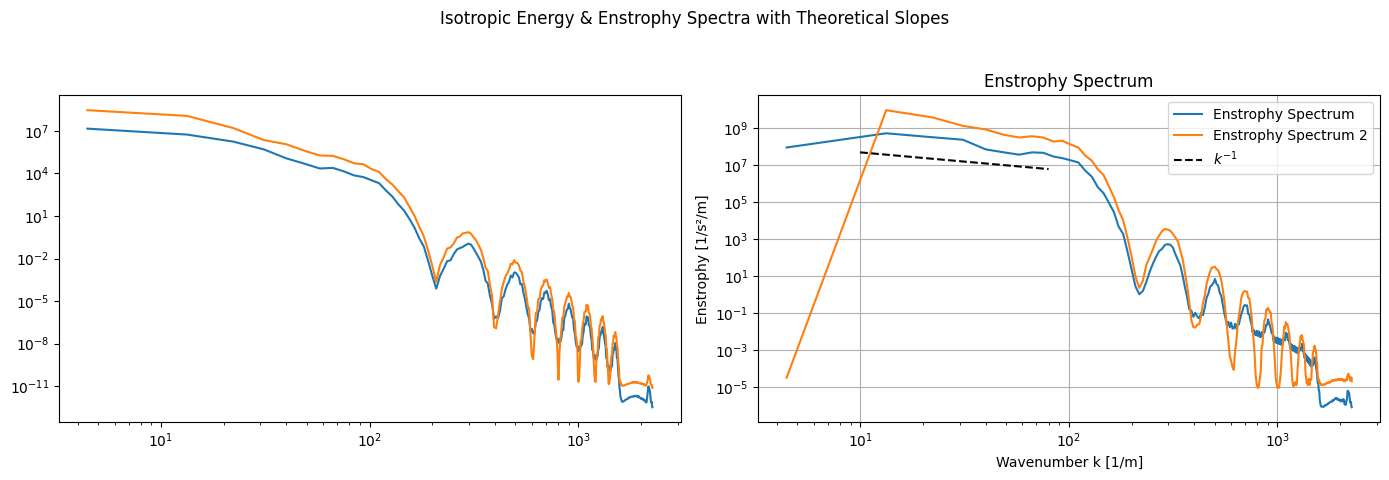

In [ ]:
def compute_energy_enstrophy_spectra(u, v, dataset_name="", Lx=1.0, Ly=1.0):
    
    nx, ny = u.shape
    dx = Lx / nx
    dy = Ly / ny

    if dataset_name == "pdebench-incomp":
        # Apply 2D Hanning window to reduce spectral leakage
        window_x = np.hanning(nx)
        window_y = np.hanning(ny)
        window = np.outer(window_x, window_y)
        u = u * window
        v = v * window

    #wavenumbers
    kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2
    K = np.sqrt(K2)

    u_hat = np.fft.fft2(u)
    v_hat = np.fft.fft2(v)

    # Energy spec
    E_k = 0.5 * (np.abs(u_hat)**2 + np.abs(v_hat)**2)

    # Vorticity spec
    w_hat = 1j * KX * v_hat - 1j * KY * u_hat
    Z_k = 0.5 * np.abs(w_hat)**2

    K_flat = K.flatten()
    E_flat = E_k.flatten()
    Z_flat = Z_k.flatten()

    k_max = np.max(K_flat)
    n_bins = nx // 2
    k_bins = np.linspace(0, k_max, n_bins + 1)
    k_bins_center = 0.5 * (k_bins[:-1] + k_bins[1:])

    # Initialize spectra and count arrays
    E_spectrum = np.zeros(n_bins)
    Z_spectrum = np.zeros(n_bins)
    counts = np.zeros(n_bins)

    # Bin accumulation
    bin_idx = np.digitize(K_flat, k_bins) - 1
    for i in range(K_flat.size):
        b = bin_idx[i]
        if 0 <= b < n_bins:
            E_spectrum[b] += E_flat[i]
            Z_spectrum[b] += Z_flat[i]
            counts[b] += 1

    # Norm
    counts[counts == 0] = 1
    E_spectrum /= counts
    Z_spectrum /= counts

    return k_bins_center, E_spectrum, Z_spectrum

k7, E7, Z7 = compute_energy_enstrophy_spectra(data[0], data[1], dataset_name='pdebench-incomp', Lx=1.0, Ly=1.0)
k8, E8, Z8 = compute_energy_enstrophy_spectra(data[0], data[1], dataset_name='test', Lx=1.0, Ly=1.0)
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Choose a range to anchor the reference lines
ref_k = np.array([10,80])

# Reference lines (manually scaled to fit visually)
ref_E_53 = (ref_k / ref_k[0])**(-5/3) * E[5]
ref_E_3 = (ref_k / ref_k[0])**(-3) * E[5]
ref_Z_1 = (ref_k / ref_k[0])**(-1) * Z[5]

# --- Energy Spectrum Plot ---
axs[0].loglog(k7, E7, label='Energy Spectrum')
axs[0].loglog(k8, E8, label='Energy Spectrum 2')

# --- Enstrophy Spectrum Plot ---
axs[1].loglog(k7, Z7, label='Enstrophy Spectrum')
axs[1].loglog(k8, Z8, label='Enstrophy Spectrum 2')

# Reference line for enstrophy
axs[1].loglog(ref_k, ref_Z_1, 'k--', label=r'$k^{-1}$')

axs[1].set_xlabel("Wavenumber k [1/m]")
axs[1].set_ylabel("Enstrophy [1/s²/m]")
axs[1].set_title("Enstrophy Spectrum")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Isotropic Energy & Enstrophy Spectra with Theoretical Slopes")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [62]:
for idx, (front, label) in enumerate(loader1):
    #print(idx, front.shape, label.shape)
    pass

931 1 0 931 tensor(2) 1001 5 3 4
935 1 4 931 tensor(2) 1001 5 3 4
939 1 8 931 tensor(2) 1001 5 3 4
943 1 12 931 tensor(2) 1001 5 3 4
947 1 16 931 tensor(2) 1001 5 3 4
951 1 20 931 tensor(2) 1001 5 3 4
955 1 24 931 tensor(2) 1001 5 3 4
959 1 28 931 tensor(2) 1001 5 3 4
963 1 32 931 tensor(2) 1001 5 3 4
967 1 36 931 tensor(2) 1001 5 3 4
971 1 40 931 tensor(2) 1001 5 3 4
975 1 44 931 tensor(2) 1001 5 3 4
979 1 48 931 tensor(2) 1001 5 3 4
983 1 52 931 tensor(2) 1001 5 3 4
987 1 56 931 tensor(2) 1001 5 3 4
991 1 60 931 tensor(2) 1001 5 3 4
995 1 64 931 tensor(2) 1001 5 3 4
999 1 68 931 tensor(2) 1001 5 3 4
1003 1 72 931 tensor(2) 1001 5 3 4
1007 1 76 931 tensor(2) 1001 5 3 4
1011 1 80 931 tensor(2) 1001 5 3 4
1015 1 84 931 tensor(2) 1001 5 3 4
1019 1 88 931 tensor(2) 1001 5 3 4
1023 1 92 931 tensor(2) 1001 5 3 4
1027 1 96 931 tensor(2) 1001 5 3 4
1031 1 100 931 tensor(2) 1001 5 3 4
1035 1 104 931 tensor(2) 1001 5 3 4
1039 1 108 931 tensor(2) 1001 5 3 4
1043 1 112 931 tensor(2) 1001 5 3 4
10

In [15]:
import torch
import torch.nn.functional as F
from torch import nn
from einops import rearrange
from einops.layers.torch import Rearrange
import numpy as np
import math
from modelComp.utils import ConvNeXtBlock, ResNetBlock, SwiGLU, MLP


def window_partition(x, window_size):

    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):

    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x



class LinearEmbedding(nn.Module):

    def __init__(self, emb_dim = 96, data_dim = (1,5,4,128,128), patch_size = (8,8), hiddenout_dim = 256, act=nn.GELU):
        super().__init__()
        
        self.B, self.T, self.C, self.H, self.W = data_dim
        self.emb_dim = emb_dim
        self.pH, self.pW = patch_size
        self.hiddenout_dim = hiddenout_dim
        self.patch_grid_res = (self.H // self.pH, self.W // self.pW)
        

        assert self.H % self.pH == 0 and self.W % self.pW == 0, "spatial input dim must be divisible by patch_size"
        assert self.H == self.W, "must be square"
        

        self.patchify = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        self.unpatchify = nn.Fold(output_size=(self.H, self.W), kernel_size=patch_size, stride=patch_size)
        self.pre_proj = nn.Sequential(
            nn.Linear(self.C * self.pH * self.pW, self.emb_dim * 2 if act == SwiGLU else self.emb_dim),
            act(),
            nn.Linear(self.emb_dim, self.emb_dim),
        )

        self.post_proj = nn.Sequential(
            nn.Linear(self.emb_dim, self.hiddenout_dim* 2 if act == SwiGLU else self.hiddenout_dim),
            act(),
            nn.Linear(self.hiddenout_dim, self.hiddenout_dim* 2 if act == SwiGLU else self.hiddenout_dim),
            act(),
            nn.Linear(self.hiddenout_dim, self.C * self.pH * self.pW),
        )

    #def get_pos_embeddings(self, t_len):
    #    return (self.time_embed[:, :t_len] + self.patch_position_embeddings).view(1, -1, self.emb_dim)  # (1, t*p*p, d)

    def encode(self, x, proj=True):

        B, T, C, H, W = x.shape
        #print(1, x.shape)
        #x = rearrange(x, "b t c h w -> (b t) c h w") #might change to .permute
        #print(2, x.shape)
        x = rearrange(x, 'b t c h w -> (b t) c h w')
        #print('before patchify', x.shape)
        x = self.patchify(x)  
        #print('after patchify', x.shape)
        #print(3, x.shape)
        x = rearrange(x, '(b t) d n -> b t n d', b=B, t=T)
        #print('after rearrange', x.shape)
        #x = rearrange(x, "(b t) d pp -> b (t pp) d", b=B) # should think about this
        #x = rearrange(x, "b d pp -> b pp d")
        #print(4, x.shape)

        # TODO: add Positional Encoding
        if proj:
            #print(5, x.shape)
            return self.pre_proj(x)#.transpose(1, 2)
        else:
            return x#.transpose(1, 2)

    def decode(self, x, proj=True):
        if proj:
            x = self.post_proj(x)  

        B, T, N, D = x.shape
        #x = rearrange(x, "b (t pp) d -> (b t) d pp", pp=self.patch_grid_res[0]*self.patch_grid_res[1]) #might change to .permute
        x = rearrange(x, 'b t n d -> (b t) d n')
        #print('before unpatchify decode', x.shape)
        x = self.unpatchify(x)  
        #print(x.shape)
        #x = rearrange(x, "(b t) c h w -> b t c h w", b=B)
        x = rearrange(x, '(b t) c h w -> b t c h w', t=T)
        #print('end decoder: ', x.shape)
        return x

class SpatiotemporalPositionalEncoding(nn.Module):
    def __init__(self, emb_dim, height, width, timesteps):
        super().__init__()
        self.emb_dim = emb_dim
        self.H = height
        self.W = width
        self.T = timesteps

        assert emb_dim % 2 == 0, "emb_dim must be divisible by 2"
        self.row_embed = nn.Parameter(torch.randn(1, self.H, 1, emb_dim // 2))
        self.col_embed = nn.Parameter(torch.randn(1, 1, self.W, emb_dim // 2))
        self.time_embed = nn.Parameter(torch.randn(1, self.T, 1, emb_dim))  # full D for time

    def forward(self, x):
        # x: (B, T, N, D)
        B, T, N, D = x.shape
        H, W = self.H, self.W
        assert N == H * W, f"Expected N = H*W = {H}x{W}, got {N}"

        # Spatial embeddings: (1, H, W, D)
        spatial = torch.cat([
            self.row_embed.expand(-1, H, W, -1),  # (1, H, W, D//2)
            self.col_embed.expand(-1, H, W, -1)   # (1, H, W, D//2)
        ], dim=-1).view(1, 1, N, D)  # -> (1, 1, N, D)

        # Temporal embedding: (1, T, 1, D)
        time = self.time_embed  # already (1, T, 1, D)

        pos = spatial + time  # broadcasts over (B, T, N, D)

        return x + pos
 
class PatchMerge(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.linear = nn.Linear(4*emb_dim, 2*emb_dim)

    def forward(self, x):
        B, T, L, C = x.shape
        H = W = int(np.sqrt(L)/2)
        x = rearrange(x, 'b t (h s1 w s2) c -> b t (h w) (s1 s2 c)', s1=2, s2=2, h=H, w=W) #might change to .permute
        x = self.linear(x)
        return x

class PatchUnMerge(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.linear = nn.Linear(emb_dim, 2*emb_dim)
    
    def forward(self, x):
        B, T, L, C = x.shape
        H = W = int(np.sqrt(L))
        #print(x.shape, H, W)
        x = self.linear(x)
        #print(x.shape)
        x = rearrange(x, 'b t (h w) (s1 s2 c) -> b t (h s1 w s2) c', s1=2, s2=2, h=H, w=W) #might change to .permute
        return x


class WindowAttention(nn.Module):

    def __init__(self, emb_dim, window_size, num_heads, qkv_bias=True, attn_drop=0., proj_drop=0.,
    use_flex_attn=True, act=nn.ReLU):

        super().__init__()
        self.emb_dim = emb_dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.qkv_bias = qkv_bias
        self.use_flex_attn = use_flex_attn # original from logits scale BCAT?

        assert emb_dim % num_heads == 0, "embedding dimension must be divisible by number of heads"
        

        if self.use_flex_attn: 
            self.flex_attn = nn.Parameter(torch.log(10 * torch.ones((num_heads, 1, 1))), requires_grad=True)
            #self.register_parameter("flex_attn", nn.Parameter(self.flex_attn))

        # mlp to generate continuous relative position bias
        self.cpb_mlp = nn.Sequential(nn.Linear(2, 512, bias=True),
                                     act(),
                                     nn.Linear(512, num_heads, bias=False))

        # get relative_coords_table
        relative_coords_h = torch.arange(-(self.window_size[0] - 1), self.window_size[0], dtype=torch.float32)
        relative_coords_w = torch.arange(-(self.window_size[1] - 1), self.window_size[1], dtype=torch.float32)
        relative_coords_table = torch.stack(
            torch.meshgrid([relative_coords_h,
                            relative_coords_w])).permute(1, 2, 0).contiguous().unsqueeze(0)  
        
        relative_coords_table[:, :, :, 0] /= (self.window_size[0] - 1)
        relative_coords_table[:, :, :, 1] /= (self.window_size[1] - 1)
        relative_coords_table *= 8  # normalize to -8, 8 TODO: understand why
        relative_coords_table = torch.sign(relative_coords_table) * torch.log2(
            torch.abs(relative_coords_table) + 1.0) / np.log2(8)

        self.register_buffer("relative_coords_table", relative_coords_table)

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w])) 
        coords_flatten = torch.flatten(coords, 1)  
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  
        relative_coords[:, :, 0] += self.window_size[0] - 1  
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(emb_dim, emb_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(emb_dim))
            self.v_bias = nn.Parameter(torch.zeros(emb_dim))
            # TODO: understand why not key bias
        else:
            self.q_bias = None
            self.v_bias = None
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_out = nn.Linear(emb_dim, emb_dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):

        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        #print(x.shape, self.qkv.weight.shape, qkv_bias.shape)
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        #print('test')
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        # cosine attention
        attn = (F.normalize(q, dim=-1) @ F.normalize(k, dim=-1).transpose(-2, -1))
        if self.use_flex_attn:
            flex_attn = torch.clamp(self.flex_attn, max=torch.log(torch.tensor(1. / 0.01, device=x.device))).exp()
            attn = attn * flex_attn

        relative_position_bias_table = self.cpb_mlp(self.relative_coords_table).view(-1, self.num_heads)
        relative_position_bias = relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1) 
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  
        relative_position_bias = 16 * torch.sigmoid(relative_position_bias)
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj_out(x)
        x = self.proj_drop(x)
        return x

    
class SpatialSwinBlock(nn.Module): #change name to something else

    def __init__(self, emb_dim, patch_grid_res, num_heads, window_size=4, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., use_flex_attn=True, 
                 act=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.emb_dim = emb_dim
        self.patch_grid_res = patch_grid_res
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        #self.use_proj_in = use_proj_in
        #print('shift_size', self.shift_size)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(emb_dim)
        #print('test')
        self.attn = WindowAttention(
            emb_dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop, use_flex_attn=use_flex_attn,
            act=nn.ReLU) # act is for relative position bias mlp so maybe not use swiglu/gelu
        #print('test')
        self.norm2 = norm_layer(emb_dim)
        mlp_hidden_dim = int(emb_dim * mlp_ratio)
        self.mlp = MLP(in_features=emb_dim, hidden_features=mlp_hidden_dim, act=act, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA (from original swin paper source code)
            H, W = self.patch_grid_res
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            #print('test')
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.patch_grid_res
        B, T, L, C = x.shape
        assert L == H * W, f"Expected L = H*W = {H}x{W}, but got L = {L}"

        shortcut = x
        x = x.view(B * T, H, W, C)  # Combine B and T for window partitioning

        # Apply cyclic shift if needed
        if self.shift_size > 0:
            x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))

        # Partition into windows and compute attention
        x_windows = window_partition(x, self.window_size)  # (num_windows*B*T, ws, ws, C)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)

        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # (num_windows*B*T, ws*ws, C)

        # Merge windows back
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        x = window_reverse(attn_windows, self.window_size, H, W)  # (B*T, H, W, C)

        # Reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))

        # Reshape back to (B, T, H*W, C)
        x = x.view(B, T, H * W, C)

        # Residual + MLP
        x = shortcut + self.norm1(x)
        x = x + self.norm2(self.mlp(x))

        return x

class TemporalBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, max_timesteps=5, mlp_ratio=4.0,
                 qkv_bias=True, drop=0.0, attn_drop=0.0, use_flex_attn=True,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.max_timesteps = max_timesteps

        self.norm1 = norm_layer(emb_dim)
        self.qkv = nn.Linear(emb_dim, emb_dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(emb_dim, emb_dim)
        self.proj_drop = nn.Dropout(drop)

        self.use_flex_attn = use_flex_attn
        if self.use_flex_attn:
            self.flex_attn = nn.Parameter(torch.log(10 * torch.ones((num_heads, 1, 1))), requires_grad=True)

        # Continuous relative positional bias (not trainable)
        relative_positions = torch.arange(-max_timesteps + 1, max_timesteps, dtype=torch.float32)
        relative_positions /= (max_timesteps - 1)
        bias_values = torch.sign(relative_positions) * torch.log2(torch.abs(relative_positions) + 1.0) / np.log2(2)
        bias_table = bias_values.unsqueeze(1).repeat(1, num_heads)
        self.register_buffer("relative_position_bias_table", bias_table)

        coords = torch.arange(max_timesteps)
        relative_coords = coords[None, :] - coords[:, None]
        relative_coords += max_timesteps - 1
        self.register_buffer("relative_position_index", relative_coords)

        self.norm2 = norm_layer(emb_dim)
        mlp_hidden_dim = int(emb_dim * mlp_ratio)
        self.mlp = MLP(in_features=emb_dim, hidden_features=mlp_hidden_dim,
                       act=act_layer, drop=drop)

    def forward(self, x):
        # x: (B, T, E, C)
        B, T, E, C = x.shape
        assert T <= self.max_timesteps, f"Input timesteps {T} exceed max_timesteps {self.max_timesteps}"

        # ============ Attention Block ============
        x_ = x.permute(0, 2, 1, 3).contiguous()  # (B, E, T, C)
        x_ = self.norm1(x_).reshape(B * E, T, C)

        qkv = self.qkv(x_).reshape(B * E, T, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.unbind(dim=2)  # (B*E, T, num_heads, head_dim)
        q = q.transpose(1, 2)  # (B*E, heads, T, head_dim)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        attn = (q @ k.transpose(-2, -1)) / (C // self.num_heads) ** 0.5
        if self.use_flex_attn:
            max_log = torch.log(torch.tensor(1. / 0.01, device=attn.device))
            flex_attn = torch.clamp(self.flex_attn, max=max_log).exp()
            attn = attn * flex_attn

        bias = self.relative_position_bias_table[self.relative_position_index[:T, :T].reshape(-1)]
        bias = bias.view(T, T, self.num_heads).permute(2, 0, 1)  # (heads, T, T)
        attn = attn + bias.unsqueeze(0)

        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)

        attn_out = (attn @ v).transpose(1, 2).reshape(B * E, T, C)
        attn_out = self.proj(attn_out)
        attn_out = self.proj_drop(attn_out)

        x_ = x_ + attn_out  # Residual 1
        x_ = x_.reshape(B, E, T, C).permute(0, 2, 1, 3).contiguous()  # (B, T, E, C)

        x_norm = self.norm2(x_)
        x = x_ + self.mlp(x_norm)  # Residual 2

        return x
    
class SwinStage(nn.Module): # change name since stage also includes patch merge formally
    
    def __init__(self, emb_dim, patch_grid_res, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., use_flex_attn=True,
                 act=nn.GELU, norm_layer=nn.LayerNorm):

        super().__init__()
        self.emb_dim = emb_dim
        self.patch_grid_res = patch_grid_res

        # build blocks
        self.blocks = nn.ModuleList([
            SpatialSwinBlock(emb_dim=emb_dim, patch_grid_res=patch_grid_res,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, 
                                 drop=drop,
                                 attn_drop=attn_drop,
                                 use_flex_attn=use_flex_attn,
                                 act=act,
                                 norm_layer=norm_layer
                                 )
            for i in range(2)])

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x

class SwinUnet(nn.Module):
    def __init__(self, emb_dim, data_dim, patch_size, hiddenout_dim, depth, 
                 stage_depths, num_heads, window_size=8, mlp_ratio=4., 
                 qkv_bias=True, drop=0., attn_drop=0., use_flex_attn=True, norm_layer=nn.LayerNorm,
                 act=nn.GELU, skip_connect=ConvNeXtBlock, gradient_flowthrough=[True, False, False]):
        super().__init__()

        # assert that every element in stage_depths is divisible by 3 except for the middle element
        assert all(stage_depths[i] % 3 == 0 for i in range(len(stage_depths)) if i != depth), "stage depth must be divisible by 3 at non-middle elements"
        assert stage_depths[depth] % 2 == 0, "stage depth must be divisible by 2 at middle element"
        self.embedding = LinearEmbedding(emb_dim, data_dim, patch_size, hiddenout_dim, act)
        self.pos_encoding = SpatiotemporalPositionalEncoding(emb_dim, data_dim[3] // patch_size[0], data_dim[4] // patch_size[1], data_dim[1])
        #print(data_dim[2] // patch_size[0], data_dim[2] // patch_size[0], data_dim[1])
        self.blockDown = [nn.ModuleList() for i in range(depth)]
        self.blockMiddle = nn.ModuleList()
        self.blockUp = [nn.ModuleList() for i in range(depth)]
        self.patchMerges = nn.ModuleList()
        self.patchUnmerges = nn.ModuleList()
        self.skip_connects = nn.ModuleList()
        # TODO: implement act 

        self.depth = depth
        self.middleblocklen = stage_depths[depth]
        self.gradient_flowthrough = gradient_flowthrough
        self.skip_connect = skip_connect

        for i in range(depth):
            patch_grid_res = (data_dim[3] // (patch_size[0] * 2**i), data_dim[4] // (patch_size[1] * 2**i))
            for j in range(stage_depths[i]):
                #print(j)
                if j % 3 == 0:
                    self.blockDown[i].append(
                        SwinStage(
                            emb_dim * 2**i, 
                            patch_grid_res=patch_grid_res, 
                            num_heads=num_heads[i], 
                            window_size=window_size, 
                            mlp_ratio = mlp_ratio, 
                            qkv_bias = qkv_bias, 
                            drop=drop,
                            attn_drop = attn_drop,
                            use_flex_attn = use_flex_attn, 
                            act=act, 
                            norm_layer=norm_layer
                        )
                    )
                    j += 1
                elif j % 3 == 2:
                    self.blockDown[i].append(
                        TemporalBlock(
                            emb_dim=emb_dim * 2**i,
                            num_heads=num_heads[i],
                            max_timesteps=data_dim[1],
                            mlp_ratio=mlp_ratio,
                            qkv_bias=qkv_bias,
                            drop=drop,
                            attn_drop=attn_drop,
                            use_flex_attn=use_flex_attn,
                            act_layer=act,
                            norm_layer=norm_layer
                        )
                    )

            self.patchMerges.append(PatchMerge(emb_dim * 2**i))


        patch_grid_res = (data_dim[3] // (patch_size[0] * 2**depth), data_dim[4] // (patch_size[1] * 2**depth))
        full_window_size = data_dim[3] // (patch_size[0] * 2**depth)
        #print('full_window_size', full_window_size)
        for i in range(stage_depths[depth]):
            if i % 2 == 0:

                self.blockMiddle.append(
                    SpatialSwinBlock(
                        emb_dim * 2**depth,
                        patch_grid_res=patch_grid_res,
                        num_heads=num_heads[depth],
                        window_size = full_window_size,
                        shift_size=0,
                        mlp_ratio=mlp_ratio,
                        qkv_bias=qkv_bias,
                        drop=0.,
                        attn_drop=0.,
                        use_flex_attn=use_flex_attn,
                        act=act,
                        norm_layer=norm_layer
                    )
                )
            if i % 2 == 1:
                self.blockMiddle.append(
                    TemporalBlock(
                        emb_dim=emb_dim * 2**depth,
                        num_heads=num_heads[depth],
                        max_timesteps=data_dim[1],
                        mlp_ratio=mlp_ratio,
                        qkv_bias=qkv_bias,
                        drop=drop,
                        attn_drop=attn_drop,
                        use_flex_attn=use_flex_attn,
                        act_layer=act,
                        norm_layer=norm_layer
                    )
                )

        for i in reversed(range(depth)):
            #print(i)
            patch_grid_res = (data_dim[3] // (patch_size[0] * 2**i), data_dim[4] // (patch_size[1] * 2**i))
            for j in range(stage_depths[depth + i + 1]):
                #print(depth + i, j)
                #print(i, emb_dim * 2**i)
                if j % 3 == 0:
                    self.blockUp[depth - i - 1].append(
                        SwinStage(
                            emb_dim * 2**i, 
                            patch_grid_res=patch_grid_res, 
                            num_heads=num_heads[2*depth - i], 
                            window_size=window_size, 
                            mlp_ratio=mlp_ratio,
                            qkv_bias=qkv_bias,
                            drop=drop,
                            attn_drop=attn_drop,
                            use_flex_attn=use_flex_attn,
                            act=act,
                            norm_layer=norm_layer
                        )
                    )
                    j += 1
                elif j % 3 == 2:
                    self.blockUp[depth - i - 1].append(
                        TemporalBlock(
                            emb_dim=emb_dim * 2**i,
                            num_heads=num_heads[2*depth - i],
                            max_timesteps=data_dim[1],
                            mlp_ratio=mlp_ratio,
                            qkv_bias=qkv_bias,
                            drop=drop,
                            attn_drop=attn_drop,
                            use_flex_attn=use_flex_attn,
                            act_layer=act,
                            norm_layer=norm_layer
                        )
                    )
                    
            self.patchUnmerges.append(PatchUnMerge(emb_dim * 2**(i+1)))
            self.skip_connects.append(skip_connect(emb_dim * 2**i)) if skip_connect is not None else None
            #print(len(self.blockUp))

    def forward(self, x):
        # shape checks
        if x.ndim != 5:
            raise ValueError(f"Input tensor must be 5D, but got {x.ndim}D")
        if x.shape[1] != self.embedding.T or x.shape[2] != self.embedding.C or x.shape[3] != self.embedding.H or x.shape[4] != self.embedding.W:
            raise ValueError(f"Input tensor must be of shape (B, {self.embedding.T}, {self.embedding.C}, {self.embedding.H}, {self.embedding.W}), but got {x.shape}")
        skips = []
        #print('module_list', self.blockDown)
        #print('block up', self.blockUp)
        x = self.embedding.encode(x, proj=True)
        x = self.pos_encoding(x)
        
        # ===== DOWN =====
        for i, module_list in enumerate(self.blockDown):
            
            if self.gradient_flowthrough[0]:
                residual = x
                for module in module_list:
                    x = module(x)
                skips.append(x)
                x = x + residual
            else:
                for module in module_list:
                    x = module(x)
                skips.append(x)

            x = self.patchMerges[i](x)

        # ===== MIDDLE =====
        residual = x
        for module in self.blockMiddle:
            #print(module)
            x = module(x)

        if self.gradient_flowthrough[1]:
            x = x + residual

        # ===== UP =====
        for i, module_list in enumerate(self.blockUp):
            x = self.patchUnmerges[i](x)
            #x = x + self.skip_connects[i](skips[self.depth - i - 1])
            skip = skips[self.depth - i - 1]
            x = x + (self.skip_connects[i](skip) if self.skip_connect is not None else skip)
            if self.gradient_flowthrough[2]:
                residual = x
                for module in module_list:
                    x = module(x)
                x = x + residual
            else:
                for module in module_list:
                    #print(module)
                    x = module(x)


        x = self.embedding.decode(x, proj=True)
        return x



In [2]:
x = torch.randn(2, 5, 2, 128, 128)
embedding = LinearEmbedding(96, x.shape, (4,4), 256)
x = embedding.encode(x)
#print('x', x.shape)
pe = SpatiotemporalPositionalEncoding(96, int(x.shape[2]**(1/2)), int(x.shape[2]**(1/2)), x.shape[1])
x = x + pe(x)
#print('x', x.shape)
stage1 = SwinStage(96, (32, 32), 2, 4, 4, 4, 0.1, 0.1, True)
x = stage1(x)
#print('x', x.shape)
merge = PatchMerge(96)
x = merge(x)
#print('x', x.shape)
middle = SpatialSwinBlock(192, (16, 16), 4, 4, 0, 4, True)
x = middle(x)
#print('x', x.shape)
middle2 = TemporalBlock(192, 4, 5, 4, True, 0.1, 0.1)
x = middle2(x)

unmerge = PatchUnMerge(192)
x = unmerge(x)
#print('x', x.shape)
stage2 = SwinStage(96, (32, 32), 2, 4, 4, 4, 0.1, 0.1, True)
x = stage2(x)
#print('x', x.shape)
x = embedding.decode(x)
#print('x', x.shape)

NameError: name 'torch' is not defined

In [55]:
model = SwinUnet(96, data_dim=(8,4,2,256,256), patch_size=(4,4), 
                 hiddenout_dim=256, depth=2, stage_depths=[3,6,6,6,3], 
                 num_heads=[3,6,12,6,3], skip_connect=ConvNeXtBlock)
x = torch.randn(8, 4, 2, 256, 256)
y = model(x)
print('y', y.shape)


y torch.Size([8, 4, 2, 256, 256])


In [38]:
x = [3,6,4,6,3]
all(x[i] % 3 == 0 for i in range(len(x)) if i != 2)


True